<a href="https://colab.research.google.com/github/riyaa14/BrainDead_Hackathon/blob/main/FastText%2BVGG19_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import classification_report, matthews_corrcoef, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

## Loading Text Embeddings

In [ ]:
df_text_train = pd.read_csv("/content/df_text_train.csv")
df_text_val = pd.read_csv("/content/df_text_val.csv")
df_text_val.head()

,id,img,label,text,tokenized_text,fasttext_vectors
0,8291,img/08291.png,1,white people be this a shoot range,"['white', 'people', 'be', 'this', 'a', 'shoot'...",[-0.09731791 0.23750562 -0.38288007 0.241222...
1,46971,img/46971.png,1,bravery at its fine,"['bravery', 'at', 'its', 'fine']",[-0.08299352 0.2168787 -0.32653594 0.207254...
2,3745,img/03745.png,1,your order come to 3750 and your white privile...,"['your', 'order', 'come', 'to', '3750', 'and',...",[-0.08208651 0.20918705 -0.30769555 0.196254...
3,83745,img/83745.png,1,it be time to send these parasite back to the ...,"['it', 'be', 'time', 'to', 'send', 'these', 'p...",[-0.09481638 0.23819618 -0.36519943 0.233848...
4,80243,img/80243.png,1,mississippi wind chime,"['mississippi', 'wind', 'chime']",[-0.06179271 0.15961621 -0.23825146 0.152376...


In [ ]:
df_text_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                8500 non-null   int64 
 1   img               8500 non-null   object
 2   label             8500 non-null   int64 
 3   text              8500 non-null   object
 4   tokenized_text    8500 non-null   object
 5   fasttext_vectors  8500 non-null   object
dtypes: int64(2), object(4)
memory usage: 398.6+ KB


## Loading Image Embeddings

In [ ]:
df_image_train = pd.read_csv("/content/df_image_train.csv")
df_image_val = pd.read_csv("/content/df_image_val.csv")
df_image_val.head()

,Unnamed: 0,id,img,label,image_embeddings
0,0,8291,img/08291.png,1,[ 0.00707572 -0.05057511 -0.11705931 -0.040771...
1,1,46971,img/46971.png,1,[-0.02525216 -0.01951682 -0.09147161 -0.068425...
2,2,3745,img/03745.png,1,[ 0.03659207 -0.04964533 -0.04078922 -0.055413...
3,3,83745,img/83745.png,1,[-0.00975812 -0.02114693 -0.073861 -0.038307...
4,4,80243,img/80243.png,1,[-0.02258018 0.00855221 -0.0263569 -0.070994...


# Joining Text and Image Embeddings in one DataFrame


In [ ]:
df_train = pd.merge(df_text_train, df_image_train, how = 'inner')
df_val = pd.merge(df_text_val, df_image_val, how = 'inner')
df_train.drop(["Unnamed: 0"], axis = 1, inplace = True)
df_val.drop(["Unnamed: 0"], axis = 1, inplace = True)
df_val.head()

,id,img,label,text,tokenized_text,fasttext_vectors,image_embeddings
0,8291,img/08291.png,1,white people be this a shoot range,"['white', 'people', 'be', 'this', 'a', 'shoot'...",[-0.09731791 0.23750562 -0.38288007 0.241222...,[ 0.00707572 -0.05057511 -0.11705931 -0.040771...
1,46971,img/46971.png,1,bravery at its fine,"['bravery', 'at', 'its', 'fine']",[-0.08299352 0.2168787 -0.32653594 0.207254...,[-0.02525216 -0.01951682 -0.09147161 -0.068425...
2,3745,img/03745.png,1,your order come to 3750 and your white privile...,"['your', 'order', 'come', 'to', '3750', 'and',...",[-0.08208651 0.20918705 -0.30769555 0.196254...,[ 0.03659207 -0.04964533 -0.04078922 -0.055413...
3,83745,img/83745.png,1,it be time to send these parasite back to the ...,"['it', 'be', 'time', 'to', 'send', 'these', 'p...",[-0.09481638 0.23819618 -0.36519943 0.233848...,[-0.00975812 -0.02114693 -0.073861 -0.038307...
4,80243,img/80243.png,1,mississippi wind chime,"['mississippi', 'wind', 'chime']",[-0.06179271 0.15961621 -0.23825146 0.152376...,[-0.02258018 0.00855221 -0.0263569 -0.070994...


## Converting Text Embeddings into Numpy Array

In [ ]:
from decimal import Decimal

def cleaning(x):
    result = []
    for i in x.split(" "):
        if i not in [" ", '[', ']' ,""]:
#             print(i)
            result.append(float(i.replace('\n', "").replace("]", "").replace("[", "")))
    return np.array(result)

In [ ]:
def getEmbedding(df, col_name):
    a = df[col_name].apply(cleaning)
    embeddings = []
    for i in a:
        embeddings.append(i)
    embeddings = np.array(embeddings)
    print(embeddings.shape)
    return embeddings

In [ ]:
text_embeddings_train = getEmbedding(df_train, "fasttext_vectors")
text_embeddings_val = getEmbedding(df_val, "fasttext_vectors")

(8500, 100)
(500, 100)


# Converting Image Embeddings into Numpy Array

In [ ]:
image_embeddings_train = getEmbedding(df_train, "image_embeddings")
image_embeddings_val = getEmbedding(df_val, "image_embeddings")

(8500, 100)
(500, 100)


# Concatenate Text and Image Embeddings

embedding = image + text

In [ ]:
embeddings_train = np.concatenate([image_embeddings_train, text_embeddings_train], axis = 1)
embeddings_train.shape

(8500, 200)

In [ ]:
embeddings_val = np.concatenate([image_embeddings_val, text_embeddings_val], axis = 1)
embeddings_val.shape

(500, 200)

In [ ]:
y_train = np.array(df_train.label)
y_val = np.array(df_val.label)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(embeddings_train, y_train)

LogisticRegression()

In [ ]:
temp_train = lr.predict(embeddings_train)
temp_val = lr.predict(embeddings_val)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print("Training Data Report")
print(classification_report(y_train.reshape(-1, 1), temp_train.reshape(-1, 1)))
print(f"MCC Score :- {matthews_corrcoef(y_train.reshape(-1, 1), temp_train.reshape(-1, 1))}")
print(f"AUC Score :- {roc_auc_score(y_train.reshape(-1, 1), temp_train.reshape(-1, 1))}")

Training Data Report
              precision    recall  f1-score   support

           0       0.67      0.93      0.78      5450
           1       0.58      0.16      0.25      3050

    accuracy                           0.66      8500
   macro avg       0.62      0.55      0.51      8500
weighted avg       0.64      0.66      0.59      8500

MCC Score :- 0.1535651670298688
AUC Score :- 0.547922995939239


In [ ]:
a = confusion_matrix(y_train.reshape(-1, 1), temp_train.reshape(-1, 1))
disp = ConfusionMatrixDisplay(a, display_labels = ["Non-Hateful", "Hateful"])
disp.plot()

In [ ]:
print("Validation Data Report")
print(classification_report(y_val.reshape(-1, 1), temp_val.reshape(-1, 1)))
print(f"MCC Score :- {matthews_corrcoef(y_val.reshape(-1, 1), temp_val.reshape(-1, 1))}")
print(f"AUC Score :- {roc_auc_score(y_val.reshape(-1, 1), temp_val.reshape(-1, 1))}")

Validation Data Report
              precision    recall  f1-score   support

           0       0.50      0.94      0.65       250
           1       0.52      0.06      0.11       250

    accuracy                           0.50       500
   macro avg       0.51      0.50      0.38       500
weighted avg       0.51      0.50      0.38       500

MCC Score :- 0.008293402278700334
AUC Score :- 0.502


In [ ]:
a = confusion_matrix(y_val.reshape(-1, 1), temp_val.reshape(-1, 1))
disp = ConfusionMatrixDisplay(a, display_labels = ["Non-Hateful", "Hateful"])
disp.plot()

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(embeddings_train, y_train)

GaussianNB()

In [ ]:
temp_train = nb.predict(embeddings_train)
temp_val = nb.predict(embeddings_val)

In [ ]:
print("Training Data Report")
print(classification_report(y_train.reshape(-1, 1), temp_train.reshape(-1, 1)))
print(f"MCC Score :- {matthews_corrcoef(y_train.reshape(-1, 1), temp_train.reshape(-1, 1))}")
print(f"AUC Score :- {roc_auc_score(y_train.reshape(-1, 1), temp_train.reshape(-1, 1))}")

Training Data Report
              precision    recall  f1-score   support

           0       0.75      0.41      0.53      5450
           1       0.42      0.76      0.54      3050

    accuracy                           0.54      8500
   macro avg       0.59      0.59      0.54      8500
weighted avg       0.63      0.54      0.53      8500

MCC Score :- 0.17184097519657449
AUC Score :- 0.5854128440366972


In [ ]:
a = confusion_matrix(y_train.reshape(-1, 1), temp_train.reshape(-1, 1))
disp = ConfusionMatrixDisplay(a, display_labels = ["Non-Hateful", "Hateful"])
disp.plot()


In [ ]:
print("Validation Data Report")
print(classification_report(y_val.reshape(-1, 1), temp_val.reshape(-1, 1)))
print(f"MCC Score :- {matthews_corrcoef(y_val.reshape(-1, 1), temp_val.reshape(-1, 1))}")
print(f"AUC Score :- {roc_auc_score(y_val.reshape(-1, 1), temp_val.reshape(-1, 1))}")

Validation Data Report
              precision    recall  f1-score   support

           0       0.51      0.33      0.40       250
           1       0.50      0.68      0.58       250

    accuracy                           0.51       500
   macro avg       0.51      0.51      0.49       500
weighted avg       0.51      0.51      0.49       500

MCC Score :- 0.012841284490609506
AUC Score :- 0.506


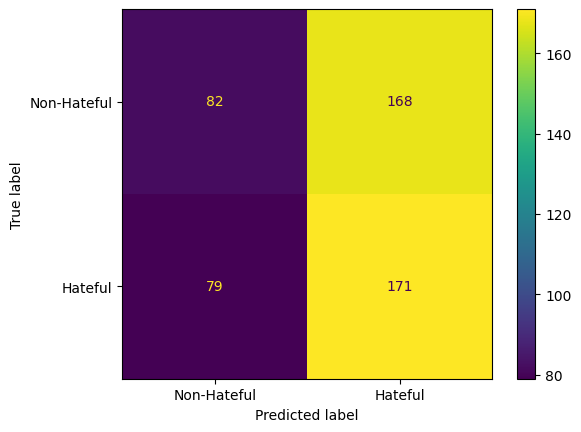

In [ ]:
a = confusion_matrix(y_val.reshape(-1, 1), temp_val.reshape(-1, 1))
disp = ConfusionMatrixDisplay(a, display_labels = ["Non-Hateful", "Hateful"])
disp.plot()